In [1]:
# Import library
import pandas as pd
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Confirm API kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"m120t6084","key":"41e31a0a1a25d3a1bf9338b0e4f053ee"}'}

In [3]:
#Install kaggle dan download dataset dari kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d stefanoleone992/imdb-extensive-dataset

 96% 79.0M/82.3M [00:00<00:00, 112MB/s] 
100% 82.3M/82.3M [00:00<00:00, 128MB/s]


1. Exploratory Data

In [4]:
# Load Data
# Variable local_zip berisi direktori lokasi file zip disimpan
local_zip = '/content/imdb-extensive-dataset.zip'

#Proses ekstrak file zip
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/imdb-extensive-dataset')
zip_ref.close()

In [5]:
#Membaca dataset yang digunakan
imdb_movies = pd.read_csv ('/content/imdb-extensive-dataset/IMDb movies.csv')
imdb_rating = pd.read_csv ('/content/imdb-extensive-dataset/IMDb ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#Melihat isi dataset imdb_movies
imdb_movies

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,Le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,$ 3507171,NaN,NaN,4.0
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,NaN,$ 7299062,NaN,6.0,4.0
85852,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,"Vineesh Aaradya, Vineesh Aaradya",RMCC Productions,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",NaN,7.9,265,NaN,NaN,NaN,NaN,NaN,NaN
85853,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",NaN,6.4,194,NaN,NaN,$ 2833,NaN,NaN,NaN


2. Data Preparation

In [7]:
# Melakukan penghapusan beberapa kolom yang tidak digunakan
columns = ['original_title',
           'year',
           'date_published',
           'duration',
           'country',
           'language',
           'director',
           'writer',
           'production_company',
           'actors',
           'description',
           'avg_vote',
           'votes',	
           'budget',
           'usa_gross_income',
           'worlwide_gross_income',
           'metascore',
           'reviews_from_users',
           'reviews_from_critics']
imdb_movies.drop(columns, inplace=True, axis=1)

In [8]:
imdb_movies

,imdb_title_id,title,genre
0,tt0000009,Miss Jerry,Romance
1,tt0000574,The Story of the Kelly Gang,"Biography, Crime, Drama"
2,tt0001892,Den sorte drøm,Drama
3,tt0002101,Cleopatra,"Drama, History"
4,tt0002130,L'Inferno,"Adventure, Drama, Fantasy"
...,...,...,...
85850,tt9908390,Le lion,Comedy
85851,tt9911196,De Beentjes van Sint-Hildegard,"Comedy, Drama"
85852,tt9911774,Padmavyuhathile Abhimanyu,Drama
85853,tt9914286,Sokagin Çocuklari,"Drama, Family"


In [9]:
# Pengecekan dataset imdb_rating
imdb_rating

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,votes_5,votes_4,votes_3,votes_2,votes_1,allgenders_0age_avg_vote,allgenders_0age_votes,allgenders_18age_avg_vote,allgenders_18age_votes,allgenders_30age_avg_vote,allgenders_30age_votes,allgenders_45age_avg_vote,allgenders_45age_votes,males_allages_avg_vote,males_allages_votes,males_0age_avg_vote,males_0age_votes,males_18age_avg_vote,males_18age_votes,males_30age_avg_vote,males_30age_votes,males_45age_avg_vote,males_45age_votes,females_allages_avg_vote,females_allages_votes,females_0age_avg_vote,females_0age_votes,females_18age_avg_vote,females_18age_votes,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,28,9,1,5,14,7.2,4.0,6.0,38.0,5.7,50.0,6.6,35.0,6.2,97.0,7.0,1.0,5.9,24.0,5.6,36.0,6.7,31.0,6.0,35.0,7.3,3.0,5.9,14.0,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,103,28,20,13,16,6.0,1.0,6.1,114.0,6.0,239.0,6.3,115.0,6.1,425.0,6.0,1.0,6.2,102.0,6.0,210.0,6.2,100.0,6.2,50.0,NaN,NaN,5.9,12.0,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,32,16,5,6,4,NaN,NaN,5.5,25.0,5.8,72.0,6.2,62.0,5.9,146.0,NaN,NaN,5.5,21.0,5.9,67.0,6.2,55.0,5.7,15.0,NaN,NaN,5.8,4.0,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,117,63,26,25,16,NaN,NaN,5.3,23.0,5.0,111.0,5.3,193.0,5.1,299.0,NaN,NaN,5.2,20.0,4.9,96.0,5.2,171.0,5.9,39.0,NaN,NaN,5.7,3.0,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,169,66,39,20,87,7.5,4.0,7.0,402.0,7.0,895.0,7.1,482.0,7.0,1607.0,8.0,2.0,7.0,346.0,7.0,804.0,7.0,396.0,7.2,215.0,7.0,2.0,7.0,52.0,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,5.3,398,5.5,6.0,13,9,26,65,104,86,32,28,15,20,6.0,1.0,5.8,42.0,5.3,137.0,5.2,101.0,5.3,267.0,6.0,1.0,5.6,28.0,5.3,121.0,5.2,97.0,6.0,26.0,NaN,NaN,6.2,11.0,5.7,11.0,5.0,2.0,5.5,12.0,6.3,22.0,5.3,214.0
85851,tt9911196,7.7,724,7.9,8.0,65,139,288,170,42,7,5,2,2,4,NaN,NaN,7.5,105.0,7.7,207.0,7.9,194.0,7.8,412.0,NaN,NaN,7.6,70.0,7.6,150.0,7.9,161.0,7.6,109.0,NaN,NaN,7.4,29.0,8.0,47.0,7.3,30.0,7.0,6.0,6.8,13.0,7.7,388.0
85852,tt9911774,7.9,265,7.8,8.0,63,29,61,61,31,5,5,6,1,3,NaN,NaN,1.0,1.0,10.0,1.0,3.0,1.0,6.0,4.0,NaN,NaN,1.0,1.0,10.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,2.0
85853,tt9914286,6.4,194,9.4,10.0,176,0,2,2,1,0,1,1,0,11,NaN,NaN,6.5,2.0,1.8,5.0,3.0,3.0,3.1,10.0,NaN,NaN,6.5,2.0,1.8,5.0,1.0,2.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,4.0,3.0,1.7,5.0,5.8,5.0


In [10]:
# Menghapus beberapa kolom yang tidak diperlukan
imdb_rating.drop(imdb_rating.columns[2:], axis=1, inplace=True)

In [11]:
imdb_rating

,imdb_title_id,weighted_average_vote
0,tt0000009,5.9
1,tt0000574,6.1
2,tt0001892,5.8
3,tt0002101,5.2
4,tt0002130,7.0
...,...,...
85850,tt9908390,5.3
85851,tt9911196,7.7
85852,tt9911774,7.9
85853,tt9914286,6.4


In [12]:
# Melakukan pengabungan dataset menjadi dataset imdb
imdb = pd.merge(imdb_movies, imdb_rating, on='imdb_title_id')
imdb = imdb[['imdb_title_id', 'title', 'genre', 'weighted_average_vote']]

In [13]:
# Melakukan filter data, dengan menghapus film yang ratingnya di bawah 7.0
imdb = imdb.drop(imdb[imdb.weighted_average_vote < 7.0].index)

In [14]:
# Melihat isi dataset imdb
imdb

,imdb_title_id,title,genre,weighted_average_vote
4,tt0002130,L'Inferno,"Adventure, Drama, Fantasy",7.0
11,tt0002844,Fantômas - À l'ombre de la guillotine,"Crime, Drama",7.0
12,tt0003014,Il calvario di una madre,Drama,7.1
13,tt0003037,Juve contre Fantômas,"Crime, Drama",7.0
16,tt0003165,Le mort qui tue,"Crime, Drama, Mystery",7.0
...,...,...,...,...
85844,tt9903716,Jessie,"Horror, Thriller",7.0
85847,tt9905412,Ottam,Drama,7.4
85848,tt9905462,Pengalila,Drama,8.8
85851,tt9911196,De Beentjes van Sint-Hildegard,"Comedy, Drama",7.7


In [15]:
# Mengetahui skala rating yang digunakan
imdb.describe()

,weighted_average_vote
count,16111.000000
mean,7.403017
std,0.398683
min,7.000000
25%,7.100000
50%,7.300000
75%,7.600000
max,9.900000


In [16]:
# Melihat informasi dataset
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16111 entries, 4 to 85852
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          16111 non-null  object 
 1   title                  16111 non-null  object 
 2   genre                  16111 non-null  object 
 3   weighted_average_vote  16111 non-null  float64
dtypes: float64(1), object(3)
memory usage: 629.3+ KB


In [17]:
# Melihat nilai null pada dataset
imdb.isnull().sum()

imdb_title_id            0
title                    0
genre                    0
weighted_average_vote    0
dtype: int64

In [18]:
# Melakukan sort dengan imdb_title_id sebagai patokan utama
imdb_fix = imdb.sort_values('imdb_title_id', ascending=True)
imdb_fix

,imdb_title_id,title,genre,weighted_average_vote
4,tt0002130,L'Inferno,"Adventure, Drama, Fantasy",7.0
11,tt0002844,Fantômas - À l'ombre de la guillotine,"Crime, Drama",7.0
12,tt0003014,Il calvario di una madre,Drama,7.1
13,tt0003037,Juve contre Fantômas,"Crime, Drama",7.0
16,tt0003165,Le mort qui tue,"Crime, Drama, Mystery",7.0
...,...,...,...,...
85844,tt9903716,Jessie,"Horror, Thriller",7.0
85847,tt9905412,Ottam,Drama,7.4
85848,tt9905462,Pengalila,Drama,8.8
85851,tt9911196,De Beentjes van Sint-Hildegard,"Comedy, Drama",7.7


In [19]:
imdb_fix.describe()

,weighted_average_vote
count,16111.000000
mean,7.403017
std,0.398683
min,7.000000
25%,7.100000
50%,7.300000
75%,7.600000
max,9.900000


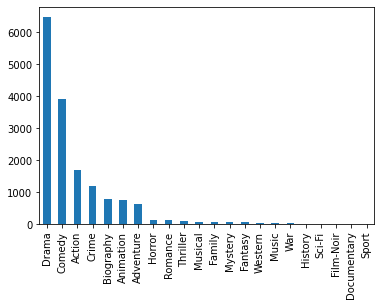

In [35]:
#Melihat Persebaaran Data Genre
imdb_fix_copy = imdb_fix.copy()
imdb_fix_copy.genre = imdb_fix_copy.genre.str.split(", ", expand = True)
imdb_fix_copy['genre'].value_counts().plot.bar()

In [22]:
# Mengetahui jumlah id dan judul
print('Jumlah id movie: ', len(imdb_fix.imdb_title_id.unique()))
print('Jumlah judul movie: ', len(imdb_fix.title.unique()))

Jumlah id movie:  16111
Jumlah judul movie:  15865


In [23]:
# Membuat duplikat
preparation=imdb_fix
preparation = preparation.drop_duplicates('imdb_title_id')
preparation

,imdb_title_id,title,genre,weighted_average_vote
4,tt0002130,L'Inferno,"Adventure, Drama, Fantasy",7.0
11,tt0002844,Fantômas - À l'ombre de la guillotine,"Crime, Drama",7.0
12,tt0003014,Il calvario di una madre,Drama,7.1
13,tt0003037,Juve contre Fantômas,"Crime, Drama",7.0
16,tt0003165,Le mort qui tue,"Crime, Drama, Mystery",7.0
...,...,...,...,...
85844,tt9903716,Jessie,"Horror, Thriller",7.0
85847,tt9905412,Ottam,Drama,7.4
85848,tt9905462,Pengalila,Drama,8.8
85851,tt9911196,De Beentjes van Sint-Hildegard,"Comedy, Drama",7.7


In [24]:
# Melakukan konversi data menjadi list
movieId = preparation['imdb_title_id'].tolist()
movieTitle = preparation['title'].tolist()
movieGenre = preparation['genre'].tolist()
 
print(len(movieId))
print(len(movieTitle))
print(len(movieGenre))

16111
16111
16111


In [25]:
# Membuat dictionary untuk data
imdbNew = pd.DataFrame({
    'imdb_title_id': movieId,
    'title': movieTitle,
    'genre': movieGenre
})
imdbNew

,imdb_title_id,title,genre
0,tt0002130,L'Inferno,"Adventure, Drama, Fantasy"
1,tt0002844,Fantômas - À l'ombre de la guillotine,"Crime, Drama"
2,tt0003014,Il calvario di una madre,Drama
3,tt0003037,Juve contre Fantômas,"Crime, Drama"
4,tt0003165,Le mort qui tue,"Crime, Drama, Mystery"
...,...,...,...
16106,tt9903716,Jessie,"Horror, Thriller"
16107,tt9905412,Ottam,Drama
16108,tt9905462,Pengalila,Drama
16109,tt9911196,De Beentjes van Sint-Hildegard,"Comedy, Drama"


In [26]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data genre
tf.fit(imdbNew['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'fi',
 'film',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'sport',
 'thriller',
 'war',
 'western']

In [27]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(imdbNew['genre']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(16111, 24)

In [28]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.62131348, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [29]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre
# Baris diisi dengan judul movie/film
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=imdbNew.title
).sample(22, axis=1).sample(10, axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,sport,war,romance,musical,animation,western,family,film,sci,drama,biography,horror,mystery,noir,fantasy,crime,adventure,music,history,documentary,action,fi
title,,,,,,,,,,,,,,,,,,,,,,
Keimusho no naka,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.509849,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Lezioni di armonia,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
"Renn, wenn du kannst",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Arya,0.0,0.000000,0.628537,0.0,0.0,0.000000,0.0,0.0,0.000000,0.303755,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.716013,0.000000
Hostiles: Ostili,0.0,0.000000,0.000000,0.0,0.0,0.971508,0.0,0.0,0.000000,0.237007,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Ishqiya,0.0,0.000000,0.725769,0.0,0.0,0.000000,0.0,0.0,0.000000,0.350745,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Holes - Buchi nel deserto,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.304727,0.0,0.0,0.000000,0.0,0.0,0.0,0.801733,0.0,0.0,0.0,0.000000,0.000000
Uomini contro,0.0,0.952477,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.304611,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Agir Romantik,0.0,0.000000,0.725769,0.0,0.0,0.000000,0.0,0.0,0.000000,0.350745,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [30]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.09456123, 0.23615238, ..., 0.23615238, 0.12040202,
        0.23615238],
       [0.09456123, 1.        , 0.40042464, ..., 0.40042464, 0.20415604,
        0.40042464],
       [0.23615238, 0.40042464, 1.        , ..., 1.        , 0.50984885,
        1.        ],
       ...,
       [0.23615238, 0.40042464, 1.        , ..., 1.        , 0.50984885,
        1.        ],
       [0.12040202, 0.20415604, 0.50984885, ..., 0.50984885, 1.        ,
        0.50984885],
       [0.23615238, 0.40042464, 1.        , ..., 1.        , 0.50984885,
        1.        ]])

In [31]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
cosine_sim_df = pd.DataFrame(cosine_sim, index=imdbNew['title'], columns=imdbNew['title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap film
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (16111, 16111)


title,Love Under New Management: The Miki Howard Story,Eksi Elmalar,Prima della rivoluzione,Haebaragi,Kutty Srank: The Sailor of Hearts
title,,,,,
Aanrijding in Moscou,0.0,0.380060,0.806078,0.136980,0.350745
Thana Theke Aschi,0.0,0.000000,0.000000,0.000000,0.000000
La collina della libertà,0.0,0.281672,0.435125,0.390541,1.000000
Kalo Pothi,0.0,0.070959,0.109616,0.645051,0.251919
"Boku wa asu, kinou no kimi to dêto suru",0.0,0.072032,0.587716,0.099873,0.255730
Io & tu - Confusione d'amore,0.0,0.380060,0.806078,0.136980,0.350745
Flirting,0.0,0.122563,1.000000,0.169934,0.435125
Victim,0.0,0.281672,0.435125,0.390541,1.000000
...e il cielo rispose...,0.0,0.475263,0.000000,0.000000,0.000000


In [32]:
# Membuat fungsi rekomendasi film
def movie_recommendations(movieTitle, similarity_data=cosine_sim_df, items=imdb_fix[['title', 'genre']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,movieTitle].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop movieTitle agar anime yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(movieTitle, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [33]:
imdbNew[imdbNew.title.eq('Pengalila')]

,imdb_title_id,title,genre
16108,tt9905462,Pengalila,Drama


In [34]:
# Mendapatkan rekomendasi film yang mirip dengan 'Pengalila'
movie_recommendations('Pengalila')

,title,genre
0,Padmavyuhathile Abhimanyu,Drama
1,Le professioniste,Drama
2,La notte dell'iguana,Drama
3,La noia,Drama
4,Chambal,Drama
5,National Theatre Live: The Lehman Trilogy,Drama
6,La dura legge,Drama
7,Adopt a Sailor,Drama
8,Ikinci pärdä,Drama
9,The Father,Drama
